#### Читаем файлы свипера и определяем парметры эквалайзера

In [6]:
import soundfile 
import librosa

from dsp import get_equalizer

Читам сигналы и ресэмплим их к частоте 44100, это частота микрофона

In [9]:
SAMPLE_RATE = 44100

sweeper_original, sweeper_original_rate = soundfile.read('../data/sweeper/audiocheck.net_hdsweep_1Hz_48000Hz_-3dBFS_30s.wav')
sweeper_recorded, sweeper_recorded_rate = soundfile.read('../data/sweeper/sweeper_recorded.wav')

sweeper_original = librosa.resample(sweeper_original, orig_sr=sweeper_original_rate, target_sr=SAMPLE_RATE)

/home/alexey/dsp/dsp/equalizer.py:33: RuntimeWarning: invalid value encountered in divide
  eqaulizer_coefs = mean_speaker / mean_original


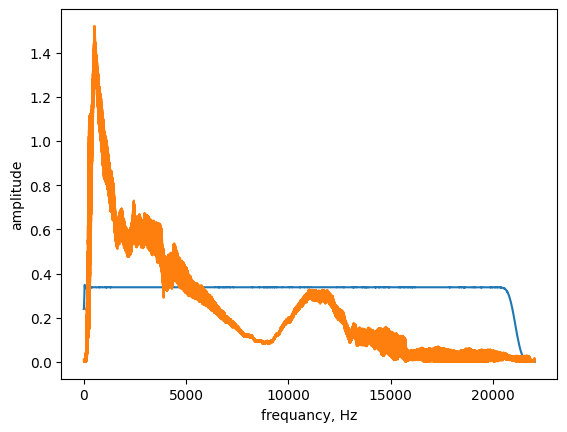

In [10]:
equalizer_coefs, bands = get_equalizer(sweeper_original, 
                                       SAMPLE_RATE, 
                                       sweeper_recorded, 
                                       SAMPLE_RATE,
                                       num_bands=64,
                                       plot=True)

#### Применяем эквалайзер к белому шуму 

In [17]:
from dsp import apply_equalizer

In [14]:
white_noise_original, white_noise_original_rate = soundfile.read('../data/white_noise/audiocheck.net_white_96k_-3dBFS.wav')
white_noise_original = librosa.resample(white_noise_original, orig_sr=white_noise_original_rate, target_sr=SAMPLE_RATE)

/home/alexey/miniconda3/envs/dsp/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/alexey/miniconda3/envs/dsp/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


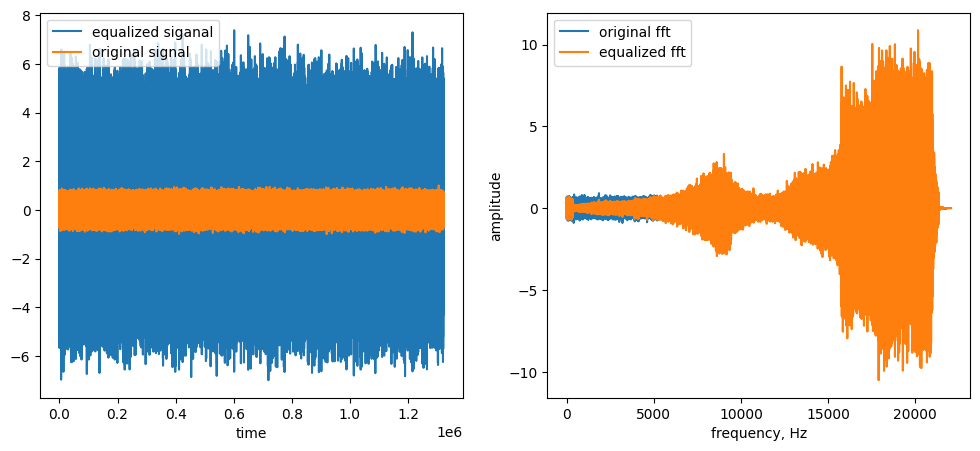

In [28]:
white_noise_equlaized, white_noise_equlaized_fft = apply_equalizer(white_noise_original,
                                                                    SAMPLE_RATE,
                                                                    equalizer_coefs,
                                                                    bands,
                                                                    plot=True)

In [29]:
soundfile.write('../data/white_noise/white_noise_equalized.wav', white_noise_equlaized, SAMPLE_RATE)

#### Считаем импкльсный отклик 

In [36]:
import numpy as np
from scipy.signal import deconvolve

import matplotlib.pyplot as plt

In [31]:
white_noise_recorded, white_noise_recorded_rate = soundfile.read('../data/white_noise/white_noise_recorded.wav')

In [32]:
# выравнивание 
start_index = (np.abs(white_noise_recorded) > 0.01).argmax()
white_noise_recorded = white_noise_recorded[start_index - 10: start_index + white_noise_equlaized.shape[0]]

In [34]:
impulse_response, reminder = deconvolve(white_noise_recorded, white_noise_original)

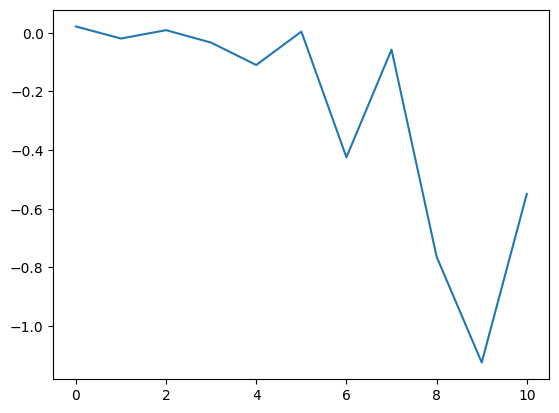

In [37]:
plt.plot(impulse_response)

#### Сворачиваем тестовый сигнал с откликом

In [39]:
from scipy.signal import convolve

In [38]:
test_signal, test_signal_rate = soundfile.read('../data/test/gt.wav')
test_signal = librosa.resample(test_signal, orig_sr=test_signal_rate, target_sr=SAMPLE_RATE)

In [40]:
test_signal_processed = convolve(test_signal, impulse_response)

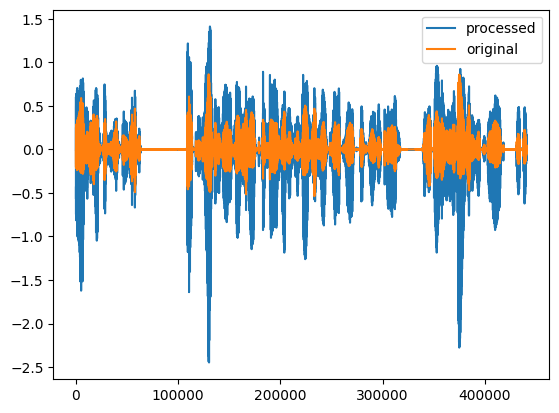

In [46]:
plt.plot(test_signal_processed, label='processed')
plt.plot(test_signal, label='original')

plt.legend()

In [45]:
soundfile.write('../data/test/gt_processed.wav', test_signal_processed, SAMPLE_RATE)

#### Выводы

Тестовый сигнал полученный сверткой с импульсным откликом мало похож на записанный сигнал, возможно из-за
1) Плохого выравнивания по времени
2) Неточного возспроизведения пложения устройств о врем записи